# Реализация базовых оптимизаторов (Momentum, Nesterov, Adam)

## Импорты

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)

## Вспомогательные функции

In [2]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def nll_loss(y_pred, y_true):
    """Negative Log-Likelihood loss"""
    eps = 1e-8
    return -torch.mean(y_true * torch.log(y_pred + eps) + (1 - y_true) * torch.log(1 - y_pred + eps))

## Класс Neuron (один нейрон)

In [3]:
class Neuron:
    def __init__(self, n_features):
        self.w = torch.randn(n_features, dtype=torch.float32)
        self.b = torch.zeros(1, dtype=torch.float32)
    
    def forward(self, X):
        return sigmoid(X @ self.w + self.b)
    
    def parameters(self):
        return [self.w, self.b]

## Оптимизаторы

In [4]:
class MomentumOptimizer:
    """Gradient Descent with Momentum
     - Добавляет инерцию в обновления параметров.
     - Новый шаг = текущий градиент + накопленная скорость.
     - Сглаживает направление обновлений и помогает избежать локальных минимумов.
    """
    def __init__(self, params, lr=0.01, beta=0.9):
        self.params = params
        self.lr = lr
        self.beta = beta
        self.v = [torch.zeros_like(p) for p in params]
    
    def step(self, grads):
        for i, p in enumerate(self.params):
            self.v[i] = self.beta * self.v[i] + (1 - self.beta) * grads[i]
            p -= self.lr * self.v[i]

class NesterovOptimizer:
    """Nesterov Accelerated Gradient
     - Улучшение Momentum: сначала делает предикт по накопленной скорости,
       а затем корректирует шаг с учётом вычисленного градиента.
     - Сходится быстрее на выпуклых задачах.
   """
    def __init__(self, params, lr=0.01, beta=0.9):
        self.params = params
        self.lr = lr
        self.beta = beta
        self.v = [torch.zeros_like(p) for p in params]
    
    def step(self, grads):
        for i, p in enumerate(self.params):
            v_prev = self.v[i].clone()
            self.v[i] = self.beta * self.v[i] + (1 - self.beta) * grads[i]
            p -= self.lr * (self.beta * v_prev + (1 - self.beta) * grads[i])

class AdamOptimizer:
    """Adam Optimizer
     - Комбинирует идеи Momentum и RMSProp.
     - Использует адаптивные моменты градиентов (m, v) и их нормализацию (bias correction).
     - Обеспечивает быструю и стабильную сходимость без подбора lr.
    """
    def __init__(self, params, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = params
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = [torch.zeros_like(p) for p in params]
        self.v = [torch.zeros_like(p) for p in params]
        self.t = 0
    
    def step(self, grads):
        self.t += 1
        for i, p in enumerate(self.params):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grads[i]
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grads[i] ** 2)
            
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            
            p -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

## Обучение одного нейрона с оптимизатором

In [5]:
def train_neuron(features, labels, optimizer_class, lr=0.1, epochs=100):
    X = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.float32)
    
    neuron = Neuron(X.shape[1])
    optimizer = optimizer_class(neuron.parameters(), lr=lr)
    losses = []

    for epoch in range(epochs):
        y_pred = neuron.forward(X)
        loss = nll_loss(y_pred, y)
        losses.append(loss.item())

        # вычисление градиентов вручную
        grad_output = y_pred - y  # dL/dy_pred
        dw = X.T @ grad_output / len(X)
        db = grad_output.mean()

        grads = [dw, db]
        optimizer.step(grads)
    
    return neuron, losses

## Тесты оптимизаторов

Momentum: финальная NLL = 0.1849
Nesterov: финальная NLL = 0.1782
Adam: финальная NLL = 0.0453


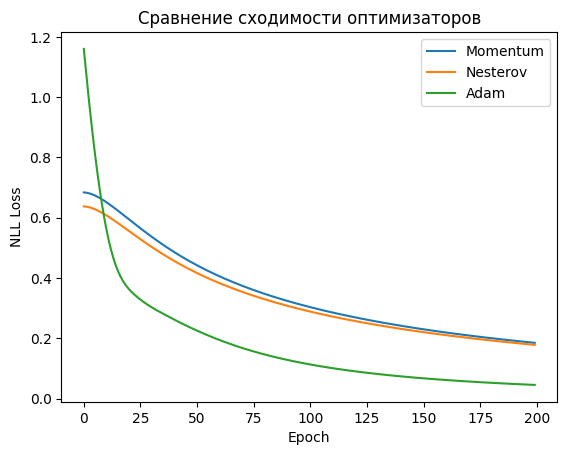

In [6]:
def test_optimizer_convergence(optimizer_class, name):
    features = [[1.0, 2.0], [2.0, 1.0], [-1.0, -2.0]]
    labels = [1, 0, 0]
    neuron, losses = train_neuron(features, labels, optimizer_class, lr=0.05, epochs=200)
    
    print(f"{name}: финальная NLL = {losses[-1]:.4f}")
    plt.plot(losses, label=name)
    return losses[-1]

final_losses = []
final_losses.append(test_optimizer_convergence(MomentumOptimizer, "Momentum"))
final_losses.append(test_optimizer_convergence(NesterovOptimizer, "Nesterov"))
final_losses.append(test_optimizer_convergence(AdamOptimizer, "Adam"))

plt.title("Сравнение сходимости оптимизаторов")
plt.xlabel("Epoch")
plt.ylabel("NLL Loss")
plt.legend()
plt.show()